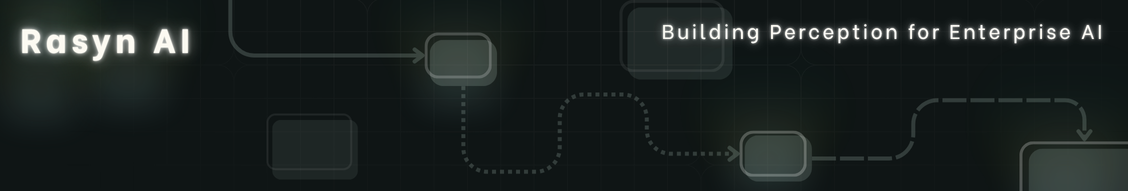

# From PaddleOCR engine to PaddleOCR-VL
> Query your medical discharge summary
---
From Text Extraction to Document Understanding: PaddleOCR-VL in Action. **A Complete Guide to Building Document Intelligence Systems**




## 📋 What This Notebook Covers

This notebook demonstrates the evolution from traditional OCR to Vision-Language Models:

1. **Traditional Approach**: PaddleOCR v3 - Text extraction
2. **Modern Approach**: PaddleOCR-VL - Document understanding
3. **Production System**: Build a complete Document Q&A application with Qwen 1.5 and PaddleOCR-VL

## 🎯 Learning Objectives

- Understand the limitations of traditional OCR
- See how VLMs change document processing
- Build a production-ready document Q&A system
- Learn best practices for deployment

**Estimated Time**: 30-40 minutes  
**Difficulty**: Intermediate  
**Hardware**: T4 GPU recommended (free tier works)
---

# ➡️ SECTION 1: ENVIRONMENT SETUP & DEPENDENCIES


In [1]:
# Install system dependencies for PDF processing
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 2s (118 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...


In [6]:
# gpu，requires GPU driver version ≥550.54.14 (Linux) or ≥550.54.14 (Windows)
!python -m pip install paddlepaddle-gpu==3.2.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu126/

!python -c "import paddle; print(paddle.__version__)"

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu126/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 GB 606.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 511.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparselt-cu12
    Found existing installation: nvidia-cusparselt-cu12 0.7.1
    Uninstalling nvidia-cusparselt-cu12-0.7.1:
      Successfully uninstalled nvidia-cusparselt-cu12-0.7.1
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing

In [7]:
# for PaddleOCR-VL
!python -m pip install -U "paddleocr[doc-parser]"
# 3. Install specific SafeTensors wheel
!python -m pip install https://paddle-whl.bj.bcebos.com/nightly/cu126/safetensors/safetensors-0.6.2.dev0-cp38-abi3-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963

In [10]:
# For settting up Unsloth for Qwen2.5-1.5B
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.33.post1
    Uninstalling xformers-0.0.33.post1:
      Successfully uninstalled xformers-0.0.33.post1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
  Using cached unsloth-2025.11.3-py3-none-any.whl.metadata (61 kB)
Using cached unsloth-2025.11.3-py3-none-any.whl (353 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 94.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
# Install RAG and UI dependencies
!pip install -q accelerate bitsandbytes
!pip install -q sentence-transformers faiss-cpu
!pip install -q gradio pillow PyMuPDF
!pip install -q markdown2
!pip install -q langchain-text-splitters nest_asyncio

print("\n All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 963.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddlepaddle-gpu 3.2.0 requires nvidia-cudnn-cu12==9.5.1.17; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.10.2.21 which is incompatible.
paddlepaddle-gpu 3.2.0 requires nvidia-cusparselt-cu12==0.6.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cusparselt-cu12 0.7.1 which is incompatible.
paddlepaddle-gpu 3.2.0 requires nvidia-nccl-cu12==2.25.1; platform_system == "Linux" and platform_machine == "x86_64", but you hav

# ➡️ SECTION 2: Get DUMMY MEDICAL DOCUMENT

In [9]:
import requests

url = 'https://github.com/Rasyn-AI/rasyn-blogs/raw/main/blogs/paddleocr_vl/Medical%20discharge%20summary.pdf'
filename = 'Medical discharge summary.pdf'

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for HTTP errors

with open(filename, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded '{filename}' successfully.")

Downloaded 'Medical discharge summary.pdf' successfully.


# ➡️ SECTION 3: TRADITIONAL OCR - PaddleOCR v3

In [1]:
import fitz  # PyMuPDF
from PIL import Image
from paddleocr import PaddleOCR
import os

# 1. Convert PDF pages to images
print("\n📄 Converting PDF to images...")
pdf_document = fitz.open("Medical discharge summary.pdf")
image_paths = []

# Create a directory for images to keep things clean
os.makedirs("page_images", exist_ok=True)

for page_num in range(len(pdf_document)):
    page = pdf_document[page_num]
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 2x zoom for better quality
    img_path = f"page_images/page_{page_num + 1}.png"
    pix.save(img_path)
    image_paths.append(img_path)
    print(f"Saved: {img_path}")

print(f"Converted {len(image_paths)} pages.")


📄 Converting PDF to images...
Saved: page_images/page_1.png
Saved: page_images/page_2.png
Saved: page_images/page_3.png
Saved: page_images/page_4.png
Saved: page_images/page_5.png
Saved: page_images/page_6.png
Converted 6 pages.


In [11]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    use_doc_orientation_classify=False, # Disables document orientation classification model via this parameter
    text_recognition_model_name="PP-OCRv5_mobile_rec",
    use_doc_unwarping=False, # Disables text image rectification model via this parameter
    use_textline_orientation=False, # Disables text line orientation classification model via this parameter
)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_mobile_rec`.
{'res': {'input_path': '/content/page_images/page_1.png', 'page_index': None, 'model_settings': {'use_doc_preprocessor': False, 'use_textline_orientation': False}, 'dt_polys': array([[[ 100,  125],
        ...,
        [ 100,  166]],

       ...,

       [[ 141, 1589],
        ...,
        [ 141, 1616]]], dtype=int16), 'text_det_params': {'limit_side_len': 64, 'limit_type': 'min', 'thresh': 0.3, 'max_side_limit': 4000, 'box_thresh': 0.6, 'unclip_ratio': 1.5}, 'text_type': 'general', 'textline_orientation_angles': array([-1, ..., -1]), 'text_rec_score_thresh': 0.0, 'return_word_box': False, 're

In [25]:
# 3. Run Inference
print("\n🔍 Processing pages...")
full_text_content = ""

for img_path in image_paths:
    print(f"Processing {img_path}...")

    # We use ocr.ocr() here instead of .predict() to get direct access
    # to the text strings without generating unnecessary image/json files.
    result = ocr.predict(img_path)

    page_text = ""
    if result and result[0]:
        # Extract just the text (index 1 -> 0) from the result list
        # Format is [[box, (text, confidence)], ...]
        lines = result[0]['rec_texts']
        page_text = "\n".join(lines)

    full_text_content += f"--- PAGE {os.path.basename(img_path)} ---\n"
    full_text_content += page_text + "\n\n"


🔍 Processing pages...
Processing page_images/page_1.png...
Processing page_images/page_2.png...
Processing page_images/page_3.png...
Processing page_images/page_4.png...
Processing page_images/page_5.png...
Processing page_images/page_6.png...


In [26]:
# output results
output_filename = "traditional_ocr_output.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    f.write(full_text_content)

print(f"\n✅ Text extraction complete. Saved to: {output_filename}")
print("First 500 characters of extracted text:\n")
print(full_text_content)


✅ Text extraction complete. Saved to: traditional_ocr_output.txt
First 500 characters of extracted text:

--- PAGE page_1.png ---
Medical discharge summary
DISCHARGE SUMMARY
General Hospitals - Greams Road, Chennai
Medical Records Department
PATIENTINFORMATION
Field
Details
Patient Name
Rajesh Kumar
Patient ID
APH-2025-999999
Age/Gender
58 Years / Male
Date of Admission
15th January 2025
Date of Discharge
22nd January 2025
Admitting
Physician
Dr. Priya Sharma, MD (Cardiology)
Consulting
Dr. Anil Verma (Endocrinology), Dr. Sarah Thomas (Internal
Physicians
Medicine)
CHIEF COMPLAINT
Patient presented with acute chest pain radiating to left arm, accompanied by shortness of
breath and profuse sweating. Symptoms started approximately 3 hours prior to admission.
DIAGNOSIS
Primary Diagnosis
Acute Myocardial Infarction (STEMI) - ST-Elevation Myocardial Infarction affecting
anterior wall
Type 2 Diabetes Melitus - Uncontrolled
Secondary Diagnosis
Hypertension - Stage 2

--- PAGE page_2.png ---


# ANALYSIS: Traditional OCR Limitations
---
❌ What Traditional OCR Gives You:
   - Raw text dump without structure
   - No understanding of document layout
   - Tables broken into disconnected text
   - No semantic relationships preserved
   - Mixed order of text elements
   
💡 Why This Is Problematic:
   - Difficult to extract specific information (e.g., "What medications?")
   - No understanding of terminology
   - Downstream processing requires extensive parsing

# ➡️ SECTION 4: MODERN APPROACH - PaddleOCR-VL

In [29]:
import paddle

if paddle.device.is_compiled_with_cuda():
    print("Flushing GPU memory...")
    paddle.device.cuda.empty_cache()
    print("GPU memory flushed. (Note: A full GPU reset might require restarting the runtime.)")
else:
    print("CUDA not available, no GPU memory to flush.")

Flushing GPU memory...
GPU memory flushed. (Note: A full GPU reset might require restarting the runtime.)


In [2]:
import os
import glob
import shutil
from paddleocr import PaddleOCRVL

# --- SETUP ---
# Clean up previous runs to avoid mixing old files
if os.path.exists("output_vl"):
    shutil.rmtree("output_vl")
os.makedirs("output_vl", exist_ok=True)

print("\n⏳ Initializing PaddleOCR-VL...")
pipeline = PaddleOCRVL()

# --- STEP 1: INFERENCE & SAVING (Per Page) ---
print("\n🔍 Processing with PaddleOCR-VL...")

for i, img_path in enumerate(image_paths):
    # Create a clean subdirectory for this specific page (e.g., output_vl/page_1)
    page_name = f"page_{i+1}" # internal naming to ensure order
    save_dir = os.path.join("output_vl", page_name)

    print(f"Analyzing Page {i+1} ({img_path})...")

    # Run prediction
    output = pipeline.predict(img_path)

    # Save individual page result
    for res in output:
        # save_to_markdown will create a .md file inside the save_dir
        res.save_to_markdown(save_path=save_dir)


⏳ Initializing PaddleOCR-VL...


/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-DocLayoutV2', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-DocLayoutV2`.
Creating model: ('PaddleOCR-VL-0.9B', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PaddleOCR-VL`.
Loading configuration file /root/.paddlex/official_models/PaddleOCR-VL/config.json
Loading weights file /root/.paddlex/official_models/PaddleOCR-VL/model.safetensors
use GQA - num_heads: 16- num_key_value_heads: 2
use GQA - num_heads: 16- num_key_value_heads: 2
use GQA - num_heads: 16- num_key_v


🔍 Processing with PaddleOCR-VL...
Analyzing Page 1 (page_images/page_1.png)...


/usr/local/lib/python3.12/dist-packages/paddle/tensor/creation.py:1088: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(), rather than paddle.to_tensor(sourceTensor).
  return tensor(
/usr/local/lib/python3.12/dist-packages/paddle/utils/decorator_utils.py:420: Warning: 
Non compatible API. Please refer to https://www.paddlepaddle.org.cn/documentation/docs/en/develop/guides/model_convert/convert_from_pytorch/api_difference/torch/torch.max.html first.
  warnings.warn(


Analyzing Page 2 (page_images/page_2.png)...
Analyzing Page 3 (page_images/page_3.png)...
Analyzing Page 4 (page_images/page_4.png)...
Analyzing Page 5 (page_images/page_5.png)...
Analyzing Page 6 (page_images/page_6.png)...


In [3]:
print("\n📚 Aggregating all markdown files into a single document...")

full_markdown_content = ""
output_file_name = "full_medical_summary.md"

# We iterate based on the count of images we processed to ensure
# we stitch Page 1 -> Page 2 -> Page 3 (and not Page 1 -> Page 10 -> Page 2)
for i in range(len(image_paths)):
    page_num = i + 1
    # Look into the specific folder we created earlier
    search_path = os.path.join("output_vl", f"page_{page_num}", "*.md")
    found_files = glob.glob(search_path)

    if found_files:
        # There should usually be only one MD file per page folder
        md_file_path = found_files[0]

        with open(md_file_path, 'r', encoding='utf-8') as f:
            content = f.read()

            # Add a header to distinguish pages in the final doc (Optional but helpful)
            full_markdown_content += f"\n\n--- PAGE {page_num} ---\n\n"
            full_markdown_content += content
            print(f"✅ Appended Page {page_num}")
    else:
        print(f"⚠️ Warning: No markdown found for Page {page_num}")

# --- STEP 3: SAVE THE MASTER FILE ---
with open(output_file_name, "w", encoding="utf-8") as f:
    f.write(full_markdown_content)

print(f"\n🎉 Success! Combined markdown saved to: {output_file_name}")


📚 Aggregating all markdown files into a single document...
✅ Appended Page 1
✅ Appended Page 2
✅ Appended Page 3
✅ Appended Page 4
✅ Appended Page 5
✅ Appended Page 6

🎉 Success! Combined markdown saved to: full_medical_summary.md


In [4]:
print("\n--- FULL EXTRACTED DOCUMENT (Markdown) ---")
print(full_markdown_content)


--- FULL EXTRACTED DOCUMENT (Markdown) ---


--- PAGE 1 ---

# Medical discharge summary DISCHARGE SUMMARY

## PATIENT INFORMATION


<table border=1 style='margin: auto; width: max-content;'><tr><td style='text-align: center;'>Field</td><td style='text-align: center;'>Details</td></tr><tr><td style='text-align: center;'>Patient Name</td><td style='text-align: center;'>Rajesh Kumar</td></tr><tr><td style='text-align: center;'>Patient ID</td><td style='text-align: center;'>APH-2025-999999</td></tr><tr><td style='text-align: center;'>Age/Gender</td><td style='text-align: center;'>58 Years / Male</td></tr><tr><td style='text-align: center;'>Date of Admission</td><td style='text-align: center;'>15th January 2025</td></tr><tr><td style='text-align: center;'>Date of Discharge</td><td style='text-align: center;'>22nd January 2025</td></tr><tr><td style='text-align: center;'>Admitting Physician</td><td style='text-align: center;'>Dr. Priya Sharma, MD (Cardiology)</td></tr><tr><td style='text-a

Advantages of VL models
---
Traditional OCR Output:
   - Unstructured text dump
   - No semantic understanding
   - Difficult to query
   - Requires extensive post-processing

Vision-Language Model Output:
   - Structured, queryable data
   - Context-aware extraction
   - Ready for downstream applications
   - Enables question-answering

# ➡️ SECTION 5: BUILD DOCUMENT Q&A SYSTEM
System Architecture:
1. Document Processing: Extract and structure content
2. Embeddings: Create vector representations
3. Vector Store: Enable semantic search
4. LLM: Generate natural language responses
5. Gradio Interface: Interactive user experience

In [17]:
import paddle

if paddle.device.is_compiled_with_cuda():
    print("Flushing GPU memory...")
    paddle.device.cuda.empty_cache()
    print("GPU memory flushed. (Note: A full GPU reset might require restarting the runtime.)")
else:
    print("CUDA not available, no GPU memory to flush.")

Flushing GPU memory...
GPU memory flushed. (Note: A full GPU reset might require restarting the runtime.)


In [5]:
# Install additional requirements
!pip install -q sentence-transformers faiss-cpu

In [6]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

In [7]:
# Initialize embedding model
print("\n⏳ Loading embedding model...")
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("✅ Embedding model loaded")


⏳ Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded


In [11]:
print("\n Performing Chunking...")
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,      # Characters per chunk
    chunk_overlap=100,   # Overlap to maintain context across boundaries
    separators=["\n\n", "\n", " ", ""] # Priority of splitting
)

# Create the chunks from the text we extracted above
raw_chunks = text_splitter.create_documents([full_markdown_content])

# Convert to list of strings for your existing RAG code
chunks = [doc.page_content for doc in raw_chunks]

print(f"✅ Generated {len(chunks)} chunks from the actual document.")
for i, chunk in enumerate(chunks[:3]):
    print(f"\n[Chunk {i+1}]:\n{chunk}")


 Performing Chunking...
✅ Generated 24 chunks from the actual document.

[Chunk 1]:
--- PAGE 1 ---

# Medical discharge summary DISCHARGE SUMMARY

## PATIENT INFORMATION

[Chunk 2]:
<table border=1 style='margin: auto; width: max-content;'><tr><td style='text-align: center;'>Field</td><td style='text-align: center;'>Details</td></tr><tr><td style='text-align: center;'>Patient Name</td><td style='text-align: center;'>Rajesh Kumar</td></tr><tr><td style='text-align: center;'>Patient ID</td><td style='text-align: center;'>APH-2025-999999</td></tr><tr><td style='text-align: center;'>Age/Gender</td><td style='text-align: center;'>58 Years / Male</td></tr><tr><td style='text-align: center;'>Date of Admission</td><td style='text-align: center;'>15th January

[Chunk 3]:
style='text-align: center;'>Date of Admission</td><td style='text-align: center;'>15th January 2025</td></tr><tr><td style='text-align: center;'>Date of Discharge</td><td style='text-align: center;'>22nd January 2025</td></tr>

In [12]:
# Generate embeddings
print("\n🔢 Generating embeddings...")
chunk_embeddings = embedding_model.encode(chunks, show_progress_bar=True)
print(f"✅ Generated embeddings: shape {chunk_embeddings.shape}")

# Create FAISS index
print("\n🗄️ Building vector store...")
dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(chunk_embeddings.astype('float32'))
print(f"✅ Vector store built with {index.ntotal} vectors")


🔢 Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated embeddings: shape (24, 384)

🗄️ Building vector store...
✅ Vector store built with 24 vectors


In [18]:
import unsloth
from unsloth import FastLanguageModel
import torch

# 1. Configuration
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 2. Load Model and Tokenizer using Unsloth
print(f"\n⏳ Loading Unsloth Model: unsloth/Qwen2.5-1.5B-Instruct...")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-1.5B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# 3. Optimize for Inference
FastLanguageModel.for_inference(model)
print("✅ Unsloth model loaded and optimized for inference!")


⏳ Loading Unsloth Model: unsloth/Qwen2.5-1.5B...
==((====))==  Unsloth 2025.11.3: Fast Qwen2 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

✅ Unsloth model loaded and optimized for inference!


In [19]:
# 4. Define the Generation Function (Updated for Unsloth)
def retrieve_and_generate(question, top_k=3):
    """
    Retrieval-Augmented Generation using Unsloth model
    """
    # Encode question
    question_embedding = embedding_model.encode([question])

    # Search similar chunks
    distances, indices = index.search(question_embedding.astype('float32'), top_k)

    # Get relevant chunks
    relevant_chunks = [chunks[idx] for idx in indices[0]]
    context = "\n\n".join(relevant_chunks)

    # Create Prompt using the Chat Template
    messages = [
        {"role": "system", "content": "You are a helpful medical assistant. Answer strictly based on the provided context. Keep answers concise."},
        {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {question}"}
    ]

    # Apply chat template (Now works because we fixed the tokenizer)
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    # Generate
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=256,
        use_cache=True,
        temperature=0.7,
        top_p=0.9
    )

    # Decode
    decoded_output = tokenizer.batch_decode(outputs)

    # Clean up the response to get just the text
    # Qwen 2.5 uses <|im_start|> and <|im_end|> tokens
    response_text = decoded_output[0].split("<|im_start|>assistant")[-1].replace("<|im_end|>", "").replace("<|endoftext|>", "").strip()

    return response_text, relevant_chunks

In [20]:
test_questions = [
    "What medications is the patient taking?",
    "What was the primary diagnosis?",
    "When is the follow-up appointment?",
    "What are the warning signs to watch for?",
    "What were the lab results showing?",
]

In [24]:
for question in test_questions:
    print(f"\n❓ Question: {question}")
    answer, sources = retrieve_and_generate(question)
    print(f"💡 Answer: {answer}")


❓ Question: What medications is the patient taking?
💡 Answer: Aspirin: 150 mg once daily (morning)
Clopidogrel (Plavix): 75 mg once daily (morning)
Atorvastatin: 80 mg once daily (bedtime)
Metoprolol Succinate: 50 mg twice daily
Ramipril: 5 mg once daily (morning)
Pantoprazole: 40 mg once daily (before breakfast)

❓ Question: What was the primary diagnosis?
💡 Answer: Acute Myocardial Infarction (STEMI), specifically a type 1 myocardial infarction involving the anterior wall.

❓ Question: When is the follow-up appointment?
💡 Answer: The follow-up appointment with Dr. Priya Sharma for the cardiology department is scheduled for 5th February 2025 at General Hospitals' Cardiology OPD.

❓ Question: What are the warning signs to watch for?
💡 Answer: Chest pain or pressure lasting > 5 minutes  
Severe shortness of breath  
Loss of consciousness or dizziness  
Irregular heartbeat or palpitations  
Severe bleeding or unusual bruising

❓ Question: What were the lab results showing?
💡 Answer: Bas

# ➡️SECTION 6: Web UI

In [27]:
import gradio as gr
import nest_asyncio

# 1. Apply the asyncio patch for Colab
nest_asyncio.apply()

def chat_with_document(question, history):
    """
    Gradio chat interface function (Updated for type='messages')
    """
    if not question.strip():
        return history, ""

    # Get answer from RAG
    answer, sources = retrieve_and_generate(question)

    # --- FIX: Use Dictionary format instead of Tuples ---
    # Old way (caused error): history.append((question, answer))

    # New way (required for type="messages"):
    history.append({"role": "user", "content": question})
    history.append({"role": "assistant", "content": answer})

    return history, ""

def create_gradio_interface():
    """
    Create Gradio interface for document Q&A
    """
    # Retrieve dynamic stats
    page_count = len(image_paths) if 'image_paths' in globals() else "N/A"
    chunk_count = len(chunks) if 'chunks' in globals() else "N/A"

    with gr.Blocks(theme=gr.themes.Soft(), title="Medical Document Q&A") as demo:
        gr.Markdown("""
        # 🏥 Medical Document Intelligence System
        ### Powered by PaddleOCR-VL + Qwen 2.5

        Ask questions about the uploaded discharge summary. The system will:
        - 🔍 Search relevant information using semantic search
        - 🤖 Generate accurate answers using RAG (Retrieval-Augmented Generation)
        - 📚 Cite sources from the original document
        """)

        with gr.Row():
            with gr.Column(scale=2):
                chatbot = gr.Chatbot(
                    label="Chat History",
                    height=400,
                    show_label=True,
                    type="messages" # This setting requires the dictionary format above
                )

                with gr.Row():
                    question_input = gr.Textbox(
                        placeholder="Ask a question about the discharge summary...",
                        label="Your Question",
                        lines=2,
                        scale=4
                    )
                    submit_btn = gr.Button("Ask", variant="primary", scale=1)

                gr.Examples(
                    examples=[
                        "What medications is the patient taking?",
                        "What was the primary diagnosis?",
                        "When are the follow-up appointments?",
                        "What lab results were abnormal?",
                        "Summarize the patient's condition",
                    ],
                    inputs=question_input,
                    label="Example Questions"
                )

            with gr.Column(scale=1):
                gr.Markdown(f"""
                ### 📋 Document Information

                **Status:** ✅ Processed
                **Source:** PDF Extraction

                **Pages Analyzed:** {page_count}
                **Knowledge Chunks:** {chunk_count}

                ---

                ### 🎯 System Features

                ✅ Context-aware responses
                ✅ Medical terminology understanding
                ✅ Multi-turn conversations
                ✅ Source citation
                ✅ Semantic search
                """)

        # Event handlers
        submit_btn.click(
            fn=chat_with_document,
            inputs=[question_input, chatbot],
            outputs=[chatbot, question_input]
        )

        question_input.submit(
            fn=chat_with_document,
            inputs=[question_input, chatbot],
            outputs=[chatbot, question_input]
        )

        gr.Markdown("""
        ---
        ### 🔧 Technical Stack

        - **Document Processing:** PaddleOCR-VL
        - **Embeddings:** Sentence-Transformers (all-MiniLM-L6-v2)
        - **Vector Store:** FAISS
        - **LLM:** Qwen 2.5 (1.5B, 4-bit quantized)
        - **Framework:** Gradio

        Built by **RASYN AI** - Building the Perception Layer for Agentic AI
        """)

    return demo

In [ ]:
# Launch Gradio interface
print("\n🚀 Launching Gradio interface...")
demo = create_gradio_interface()
demo.launch(share=True, debug=True)


🚀 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3bffa24e6bf53953a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🎉 What We've Built:

1. ✅ Created realistic medical discharge summary
2. ✅ Demonstrated traditional OCR limitations (text dump)
3. ✅ Showed VLM advantages (structured understanding)
4. ✅ Built complete RAG system with:
   - Semantic search (FAISS)
   - Document embeddings
   - LLM-powered Q&A (Qwen 1.5)
5. ✅ Deployed interactive Gradio interface


🔗 Next Steps:
- Test the Gradio interface above
- Try different questions
- Experiment with your own documents
- Deploy to production

📚 Resources:
- PaddleOCR: https://github.com/PaddlePaddle/PaddleOCR
- PaddleOCR-VL: https://huggingface.co/PaddlePaddle/PaddleOCR-VL
- RASYN AI: https://www.rasyn.tech

💬 Questions? Reach out to info@rasyn.tech